In [1]:
# !pip install pyarrow

In [2]:
# !pip install igraph

# Disease-Gene Association Harmonisation

This notebook harmonizes OpenTargets disease-gene associations by:
1. Loading gene-disease associations from OpenTargets
2. Mapping diseases to ICD10 codes using semantic embeddings
3. Merging gene association vectors for diseases with the same ICD10 code
4. Computing Pearson correlations between ICD-harmonized diseases
5. Comparing with hospital data and generating visualizations

In [3]:
import pandas as pd
import glob
import igraph as ig
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pyreadr
import icd10
from scipy.stats import pearsonr, fisher_exact
from statsmodels.stats.multitest import multipletests
import torch
from sentence_transformers import SentenceTransformer, util
import os
import time
import pickle
import json
from Bio import Entrez
from urllib.error import HTTPError

# Configuration
MERGE_METHOD = 'max'  # 'max' or 'mean' - method for merging gene vectors when multiple diseases map to same ICD code
SIMILARITY_THRESHOLD = 0.8  # Threshold for semantic similarity matching
harmonized_fname = 'harmonized_open_target.csv'

print(f"Configuration:")
print(f"  Merge method: {MERGE_METHOD}")
print(f"  Similarity threshold: {SIMILARITY_THRESHOLD}")

/Users/vladimirk/opt/anaconda3/envs/jax_arm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration:
  Merge method: max
  Similarity threshold: 0.8


## Step 1: Load OpenTargets Data

In [4]:
# Load OpenTargets association data
data_dir = "data/open_targets_25_09/association_type/"
df = pd.read_parquet(data_dir, engine="pyarrow")
print(f"Loaded {len(df):,} associations")
print(f"\nFirst few rows:")
print(df.head())

Loaded 4,200,235 associations

First few rows:
         datatypeId       datasourceId    diseaseId         targetId  \
0  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000010671   
1  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000110848   
2  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000165025   
3  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000197943   
4  affected_pathway  cancer_biomarkers  EFO_0000178  ENSG00000066468   

      score  evidenceCount  
0  0.607931              1  
1  0.607931              1  
2  0.607931              1  
3  0.607931              1  
4  0.607931              1  


In [5]:
# Remove literature evidence
print(f"\nFiltering out literature evidence...")
print(f"Before: {len(df):,} associations")
df = df[df['datatypeId'] != 'literature']
print(f"After: {len(df):,} associations")
print(f"\nData types remaining:")
print(df['datatypeId'].value_counts())


Filtering out literature evidence...
Before: 4,200,235 associations
After: 1,779,799 associations

Data types remaining:
datatypeId
genetic_association    714130
animal_model           690354
rna_expression         166503
somatic_mutation        96504
known_drug              74187
affected_pathway        38121
Name: count, dtype: int64


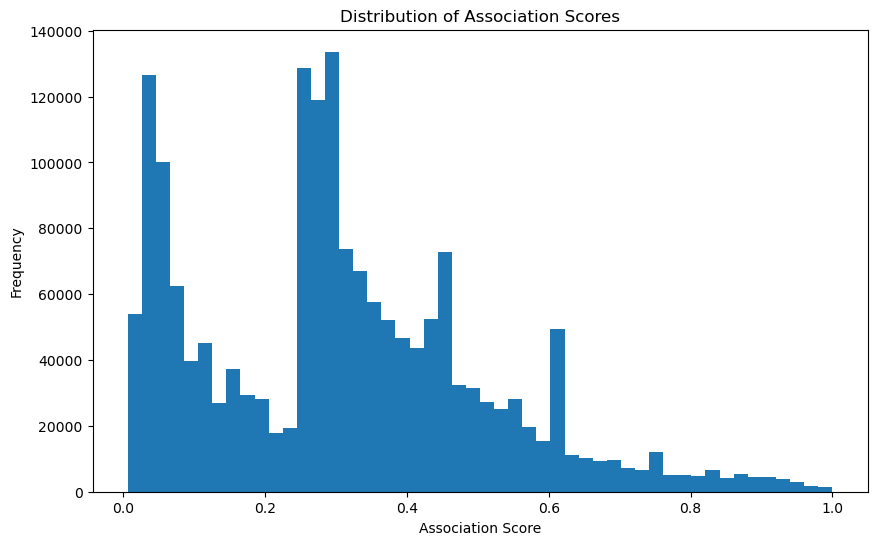

In [6]:
# Check score distribution
plt.figure(figsize=(10, 6))
plt.hist(df['score'], bins=50)
plt.xlabel('Association Score')
plt.ylabel('Frequency')
plt.title('Distribution of Association Scores')
plt.show()

In [7]:
# Aggregate scores using bounded harmonic sum
def bounded_harmonic_sum(scores):
    S = scores.sum()
    return S / (1.0 + S)

print("Aggregating scores by disease-gene pairs...")
final_scores = (
    df.groupby(['diseaseId', 'targetId'])['score']
      .apply(bounded_harmonic_sum)
      .reset_index(name='customAssociationScore')
)
print(f"Created {len(final_scores):,} unique disease-gene associations")
print(final_scores.head())

Aggregating scores by disease-gene pairs...
Created 1,725,160 unique disease-gene associations
    diseaseId         targetId  customAssociationScore
0  DOID_10113  ENSG00000011677                0.057309
1  DOID_10113  ENSG00000022355                0.057309
2  DOID_10113  ENSG00000100342                0.378083
3  DOID_10113  ENSG00000113327                0.057309
4  DOID_10113  ENSG00000113578                0.347233


In [8]:
# Download from OpenTargets
!wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/target  -P data/open_targets_25_09/target
!wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/disease -P data/open_targets_25_09/disease

file_list = glob.glob("data/open_targets_25_09/target/*.parquet")
data_frames_list = [pd.read_parquet(file) for file in file_list]
combined_targets = pd.concat(data_frames_list, ignore_index=True)
combined_targets = combined_targets.rename(columns={'id': 'targetId'})
combined_targets.to_csv("data/open_targets_25_09/gene_map.csv", index=False)
combined_targets 

file_list = glob.glob("data/open_targets_25_09/disease/*.parquet")
data_frames_list = [pd.read_parquet(file) for file in file_list]
combined_disease = pd.concat(data_frames_list, ignore_index=True)
combined_disease = combined_disease.rename(columns={'id': 'diseaseId'})
combined_disease.to_csv("data/open_targets_25_09/disease_map.csv", index=False)
combined_disease 

--2026-02-16 00:48:39--  ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/target
           => ‘data/open_targets_25_09/target/.listing’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/opentargets/platform/25.09/output ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]   2.90K  --.-KB/s    in 0s      

2026-02-16 00:48:40 (47.9 MB/s) - ‘data/open_targets_25_09/target/.listing’ saved [2965]

Removed ‘data/open_targets_25_09/target/.listing’.
--2026-02-16 00:48:40--  ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/target/target
           => ‘data/open_targets_25_09/target/.listing’
==> CWD (1) /pub/databases/opentargets/platform/25.09/output/target ... done.
==> PASV ... done.    ==> LIST .

,diseaseId,code,name,description,dbXRefs,parents,synonyms,obsoleteTerms,obsoleteXRefs,children,ancestors,therapeuticAreas,descendants,ontology
0,DOID_0050890,http://purl.obolibrary.org/obo/DOID_0050890,synucleinopathy,A neurodegenerative disease that is characteri...,"[UMLS:C5191670, MONDO:0000510, MEDGEN:1682194,...","[MONDO_0019052, MONDO_0021179, MONDO_0024237]",{'hasExactSynonym': ['alpha Synucleinopathies'...,[],[],"[EFO_0006792, EFO_1001050]","[MONDO_0019052, MONDO_0021179, EFO_0009386, MO...","[OTAR_0000020, EFO_0000618, OTAR_0000018]","[MONDO_0000211, MONDO_0016418, MONDO_0014835, ...","{'isTherapeuticArea': False, 'leaf': False, 's..."
1,DOID_10113,http://purl.obolibrary.org/obo/DOID_10113,trypanosomiasis,Infection with protozoa of the genus trypanosoma.,"[MONDO:0000940, NANDO:2200774, ICD10CM:B56, DO...",[MONDO_0002428],{'hasExactSynonym': ['Trypanosoma caused disea...,[],[],"[MONDO_0001444, EFO_0005225, EFO_0008559]","[EFO_0001067, EFO_0005741, MONDO_0002428]",[EFO_0005741],"[MONDO_0001444, EFO_0005225, EFO_0008559, EFO_...","{'isTherapeuticArea': False, 'leaf': False, 's..."
2,DOID_10718,http://purl.obolibrary.org/obo/DOID_10718,giardiasis,An infection of the small intestine caused by ...,"[MEDGEN:42213, SCTID:10679007, DOID:10718, icd...","[MONDO_0002428, EFO_0009561]","{'hasExactSynonym': ['beaver fever', 'giardias...",[],[],[],"[EFO_0009431, EFO_0001067, MONDO_0043424, EFO_...","[EFO_0010282, EFO_0005741]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
3,DOID_13406,http://purl.obolibrary.org/obo/DOID_13406,pulmonary sarcoidosis,Sarcoidosis affecting the lung parenchyma. It ...,"[MONDO:0001708, MESH:D017565, SNOMEDCT:2436900...","[MONDO_0017026, MONDO_0019338]","{'hasExactSynonym': ['pulmonary sarcoidosis', ...",[],[],[EFO_1001232],"[MONDO_0019751, EFO_1001986, EFO_0004244, EFO_...","[OTAR_0000006, OTAR_0000010]",[EFO_1001232],"{'isTherapeuticArea': False, 'leaf': False, 's..."
4,DOID_1947,http://purl.obolibrary.org/obo/DOID_1947,trichomoniasis,An infection that is caused by Trichomonas.,"[NCIt:C35720, ICD9CM:131, MONDO:0002154, ICD9:...",[MONDO_0002428],"{'hasExactSynonym': ['trichomonas infection', ...",[],[],"[MONDO_0030705, MONDO_0030707, MONDO_0030708, ...","[MONDO_0002428, EFO_0005741, EFO_0001067]",[EFO_0005741],"[EFO_0007521, MONDO_0030708, MONDO_0030705, MO...","{'isTherapeuticArea': False, 'leaf': False, 's..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39525,Orphanet_99942,http://www.orpha.net/ORDO/Orphanet_99942,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[ICD10:G60.0, OMIM:607677]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2I'], 'hasRelatedSyno...",[],[],[],"[EFO_0000508, EFO_0009387, OTAR_0000018, MONDO...","[OTAR_0000018, EFO_0000618]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39526,Orphanet_99943,http://www.orpha.net/ORDO/Orphanet_99943,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[ICD10:G60.0, OMIM:607736]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2J'], 'hasRelatedSyno...",[],[],[],"[MONDO_0018993, MONDO_0100545, MONDO_0015626, ...","[EFO_0000618, OTAR_0000018]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39527,Orphanet_99945,http://www.orpha.net/ORDO/Orphanet_99945,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[OMIM:608673, ICD10:G60.0]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2L'], 'hasRelatedSyno...",[],[],[],"[MONDO_0020127, EFO_0003100, MONDO_0018993, EF...","[EFO_0000618, OTAR_0000018]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39528,Orphanet_99946,http://www.orpha.net/ORDO/Orphanet_99946,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[OMIM:118210, ICD10:G60.0]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2A1'], 'hasRelatedSyn...",[],[],[],"[EFO_0000508, EFO_0004149, EFO_0003100, MONDO_...","[EFO_0000618, OTAR_

In [9]:
# Load gene and disease mappings
print("\nLoading gene and disease metadata...")
combined_targets = pd.read_csv("data/open_targets_25_09/gene_map.csv")
combined_disease = pd.read_csv("data/open_targets_25_09/disease_map.csv")

print(f"Loaded {len(combined_targets):,} genes")
print(f"Loaded {len(combined_disease):,} diseases")

# Create edge list with disease and gene names
disease_edge = pd.merge(final_scores, combined_disease, on="diseaseId")
disease_edge = pd.merge(disease_edge, combined_targets, on='targetId')
disease_edge = disease_edge[["name", "approvedSymbol", "customAssociationScore"]]
print(f"\nCreated edge list with {len(disease_edge):,} entries")
print(disease_edge.head())


Loading gene and disease metadata...
Loaded 78,726 genes
Loaded 39,530 diseases

Created edge list with 1,725,160 entries
              name approvedSymbol  customAssociationScore
0  trypanosomiasis         GABRA3                0.057309
1  trypanosomiasis         GABRA1                0.057309
2  trypanosomiasis          APOL1                0.378083
3  trypanosomiasis         GABRG2                0.057309
4  trypanosomiasis           FGF1                0.347233


In [10]:
# Filter out measurement-related diseases
measurement_keywords = ['measurement', 'level', 'concentration', 'trait',
                        'response', 'ratio', 'presence', 'status', 'microdeletion', 
                        'microduplication', 'deletion', 'duplication']

pattern = '|'.join(measurement_keywords)
disease_edge_filtered = disease_edge[~disease_edge['name'].str.contains(pattern, case=False, na=False)]

print(f"Filtered out {len(disease_edge) - len(disease_edge_filtered):,} measurement-related associations")
print(f"Remaining: {len(disease_edge_filtered):,} associations")

Filtered out 256,691 measurement-related associations
Remaining: 1,468,469 associations


In [11]:
# =============================================================================
# STEP 2-3: ICD MAPPING AND GENE VECTOR MERGING (CONSOLIDATED)
# This cell combines multiple steps to ensure all variables are created in order
# =============================================================================

# -----------------------------------------------------------------------------
# Part 1: Load ICD-10 codes
# -----------------------------------------------------------------------------
print("=" * 80)
print("STEP 2: Load ICD-10 codes")
print("=" * 80)

df_icd = pd.read_csv("data/DiagAll_Eng.csv")
# NOTE: Keeping original ICD descriptions (no replacement)
df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])
icd_dict = dict(zip(df_icd["ShortDescription"], df_icd["Code"]))
icd_dict = {k.replace('"', ''): v for k, v in icd_dict.items()}
icd_descriptions = list(icd_dict.keys())
icd_codes = list(icd_dict.values())

print(f"✓ Loaded {len(icd_dict):,} ICD-10 codes")
print(f"  Sample: {list(icd_dict.items())[:3]}")

# Verify special cases
special_cases = ['Unspecified dementia', "Alzheimer's disease", 'Vascular dementia']
for case in special_cases:
    if case in icd_dict:
        print(f"  ✓ '{case}' -> {icd_dict[case]}")

# -----------------------------------------------------------------------------
# Part 2: Load or create embeddings
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 2: Load embeddings")
print("=" * 80)

model_cache_dir = "./models/pubmedbert-base-embeddings"
embeddings_cache_file = "./models/disease_embeddings_cache.pkl"

def load_model_with_retry(model_name, cache_dir, max_retries=5, initial_delay=2):
    """Load sentence transformer model with exponential backoff retry strategy."""
    delay = initial_delay
    for attempt in range(max_retries):
        try:
            if os.path.exists(cache_dir):
                print(f'Loading model from local cache: {cache_dir}')
                return SentenceTransformer(cache_dir)
            else:
                print(f'Attempt {attempt + 1}/{max_retries}: Downloading model...')
                model = SentenceTransformer(model_name)
                os.makedirs(cache_dir, exist_ok=True)
                model.save(cache_dir)
                print(f'✓ Model saved to {cache_dir}')
                return model
        except Exception as e:
            if attempt < max_retries - 1:
                print(f'⚠️ Attempt {attempt + 1} failed: {str(e)[:100]}')
                print(f'   Retrying in {delay} seconds...')
                time.sleep(delay)
                delay *= 2
            else:
                raise Exception(f"Failed to load model after {max_retries} attempts: {e}")

unique_diseases = disease_edge_filtered['name'].unique()
print(f"Found {len(unique_diseases):,} unique diseases to map")

if os.path.exists(embeddings_cache_file):
    print(f'Loading embeddings from cache...')
    with open(embeddings_cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        icd_embeddings = cache_data['icd_embeddings']
        all_disease_embeddings = cache_data['disease_embeddings']
        disease_embeddings = {d: all_disease_embeddings[d] for d in unique_diseases if d in all_disease_embeddings}
        missing_diseases = set(unique_diseases) - set(disease_embeddings.keys())
        if missing_diseases:
            print(f"Creating {len(missing_diseases)} new embeddings...")
            model = load_model_with_retry("NeuML/pubmedbert-base-embeddings", model_cache_dir)
            for disease in tqdm(missing_diseases, desc="Encoding"):
                disease_embeddings[disease] = model.encode(disease, convert_to_tensor=False)
    print(f'✓ Loaded embeddings from cache')
else:
    print('Computing embeddings from scratch...')
    model = load_model_with_retry("NeuML/pubmedbert-base-embeddings", model_cache_dir)
    print('Creating ICD10 embeddings...')
    icd_embeddings = model.encode(icd_descriptions, convert_to_tensor=False)
    print('Creating disease embeddings...')
    disease_embeddings = {disease: model.encode(disease, convert_to_tensor=False)
                          for disease in tqdm(unique_diseases, desc="Encoding")}
    os.makedirs(os.path.dirname(embeddings_cache_file), exist_ok=True)
    with open(embeddings_cache_file, 'wb') as f:
        pickle.dump({'icd_embeddings': icd_embeddings, 'disease_embeddings': disease_embeddings}, f)
    print(f'✓ Embeddings saved to cache')

# -----------------------------------------------------------------------------
# Part 3: Map diseases to ICD codes
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 2: Map diseases to ICD-10")
print("=" * 80)

# Precompute normalized ICD embeddings
icd_embeddings_np = np.asarray(icd_embeddings, dtype=np.float32)
icd_norms = np.linalg.norm(icd_embeddings_np, axis=1, keepdims=True)
icd_embeddings_np = icd_embeddings_np / icd_norms

def map_disease_to_icd(disease_name, disease_embedding, icd_dict,
                       icd_descriptions, icd_embeddings_np, similarity_threshold):
    """Map a disease name to ICD-10 description using cosine similarity."""
    if disease_name in icd_dict:
        return disease_name
    v = np.asarray(disease_embedding, dtype=np.float32)
    v_norm = np.linalg.norm(v)
    if v_norm == 0:
        return "UNKNOWN"
    v = v / v_norm
    similarities = icd_embeddings_np @ v
    best_match_idx = int(np.argmax(similarities))
    best_score = similarities[best_match_idx]
    if best_score >= similarity_threshold:
        return icd_descriptions[best_match_idx]
    else:
        if 'alzheimer' in disease_name.lower():
            return "Alzheimer's disease"
        elif 'dementia' in disease_name.lower():
            return 'Dementia'  # F00
        else:
            return "UNKNOWN"

# Map all diseases
print("Mapping diseases to ICD-10 codes...")
diseases_mapping = {}
for disease in tqdm(unique_diseases, desc="Mapping"):
    diseases_mapping[disease] = map_disease_to_icd(
        disease, disease_embeddings[disease], icd_dict,
        icd_descriptions, icd_embeddings_np, SIMILARITY_THRESHOLD
    )

total_diseases = len(diseases_mapping)
mapped_diseases = sum(v != "UNKNOWN" for v in diseases_mapping.values())
unknown_diseases = total_diseases - mapped_diseases

print(f"\n📊 Mapping Statistics:")
print(f"   Total: {total_diseases:,}")
print(f"   Mapped: {mapped_diseases:,} ({mapped_diseases/total_diseases*100:.1f}%)")
print(f"   Unknown: {unknown_diseases:,} ({unknown_diseases/total_diseases*100:.1f}%)")

# Save mapping
filtered_mapping = {d: icd for d, icd in diseases_mapping.items() if icd != "UNKNOWN"}
with open("diseases_to_icd_mapped.json", "w", encoding="utf-8") as f:
    json.dump(filtered_mapping, f, indent=2, ensure_ascii=False)
print(f"✓ Saved {len(filtered_mapping):,} mappings to diseases_to_icd_mapped.json")

# -----------------------------------------------------------------------------
# Part 4: Apply ICD mapping to edge list
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 3: Apply ICD mapping")
print("=" * 80)

disease_edge_mapped = disease_edge_filtered.copy()
disease_edge_mapped['icd_name'] = disease_edge_mapped['name'].map(diseases_mapping)
before_count = len(disease_edge_mapped)
disease_edge_mapped = disease_edge_mapped[disease_edge_mapped['icd_name'] != 'UNKNOWN']
after_count = len(disease_edge_mapped)

print(f"Filtered {before_count - after_count:,} unmapped associations")
print(f"Remaining: {after_count:,} associations")

unique_original = disease_edge_mapped['name'].nunique()
unique_icd = disease_edge_mapped['icd_name'].nunique()

print(f"\nDiseases before ICD: {unique_original:,}")
print(f"Diseases after ICD: {unique_icd:,}")
print(f"To be merged: {unique_original - unique_icd:,}")

print("\nSample mappings:")
sample = disease_edge_mapped[['name', 'icd_name']].drop_duplicates().head(5)
for _, row in sample.iterrows():
    print(f"  {row['name']} -> {row['icd_name']}")

# -----------------------------------------------------------------------------
# Part 5: Merge gene vectors
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 3: Merge gene vectors")
print("=" * 80)
print(f"Using merge method: {MERGE_METHOD}")

if MERGE_METHOD == 'max':
    disease_edge_merged = disease_edge_mapped.groupby(
        ['icd_name', 'approvedSymbol']
    )['customAssociationScore'].max().reset_index()
elif MERGE_METHOD == 'mean':
    disease_edge_merged = disease_edge_mapped.groupby(
        ['icd_name', 'approvedSymbol']
    )['customAssociationScore'].mean().reset_index()
else:
    raise ValueError(f"Unknown merge method: {MERGE_METHOD}")

disease_edge_merged.rename(columns={'icd_name': 'name'}, inplace=True)

print(f"✓ Merged to {len(disease_edge_merged):,} associations")
print(f"  Unique diseases: {disease_edge_merged['name'].nunique():,}")
print(f"  Unique genes: {disease_edge_merged['approvedSymbol'].nunique():,}")

# -----------------------------------------------------------------------------
# Part 6: Create pivot table
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 3: Create disease-gene matrix")
print("=" * 80)

disease_gene_matrix = disease_edge_merged.pivot_table(
    index="approvedSymbol",
    columns="name",
    values="customAssociationScore",
    aggfunc="mean",
    fill_value=0)

print(f"✓ Matrix shape: {disease_gene_matrix.shape}")
print(f"  Genes: {disease_gene_matrix.shape[0]:,}")
print(f"  Diseases: {disease_gene_matrix.shape[1]:,}")
print(f"  Sparsity: {(disease_gene_matrix.values == 0).sum() / disease_gene_matrix.size * 100:.1f}%")

# -----------------------------------------------------------------------------
# Part 7: Create Dementia umbrella at gene-vector level
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("STEP 3b: Create Dementia umbrella at gene-vector level")
print("=" * 80)

dementia_subtypes = ['Unspecified dementia', "Dementia in Alzheimer's disease",
                     'Vascular dementia', "Alzheimer's disease"]
available_subtypes = [s for s in dementia_subtypes if s in disease_gene_matrix.columns]
print(f"Found dementia subtypes: {available_subtypes}")

if available_subtypes:
    # Create Dementia column as max across all subtype gene vectors
    disease_gene_matrix['Dementia'] = disease_gene_matrix[available_subtypes].max(axis=1)
    n_dem_genes = (disease_gene_matrix['Dementia'] > 0).sum()
    print(f"\u2713 Created 'Dementia' umbrella column: {n_dem_genes:,} associated genes")

    # Drop individual subtypes EXCEPT Alzheimer's disease (G30), needed for second heatmap panel
    subtypes_to_drop = [s for s in available_subtypes if s != "Alzheimer's disease"]
    disease_gene_matrix.drop(columns=subtypes_to_drop, inplace=True)
    print(f"  Dropped subtypes: {subtypes_to_drop}")
    print(f"  Kept: Alzheimer's disease (G30) and Dementia (umbrella)")
else:
    print("\u26a0\ufe0f No dementia subtypes found in matrix")

print(f"  Updated matrix shape: {disease_gene_matrix.shape}")

print("\n" + "=" * 80)
print("STEPS 2-3 COMPLETED")
print("=" * 80)

STEP 2: Load ICD-10 codes
✓ Loaded 1,075 ICD-10 codes
  Sample: [('Healthy', '000'), ('Cholera', 'A00'), ('Typhoid and paratyphoid fevers', 'A01')]
  ✓ 'Unspecified dementia' -> F03
  ✓ 'Alzheimer's disease' -> G30
  ✓ 'Vascular dementia' -> F01

STEP 2: Load embeddings
Found 14,418 unique diseases to map
Loading embeddings from cache...
Creating 1 new embeddings...
Loading model from local cache: ./models/pubmedbert-base-embeddings


Encoding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


✓ Loaded embeddings from cache

STEP 2: Map diseases to ICD-10
Mapping diseases to ICD-10 codes...


Mapping: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 20594.18it/s]



📊 Mapping Statistics:
   Total: 14,418
   Mapped: 915 (6.3%)
   Unknown: 13,503 (93.7%)
✓ Saved 915 mappings to diseases_to_icd_mapped.json

STEP 3: Apply ICD mapping
Filtered 1,285,745 unmapped associations
Remaining: 182,724 associations

Diseases before ICD: 915
Diseases after ICD: 422
To be merged: 493

Sample mappings:
  trypanosomiasis -> African trypanosomiasis
  pulmonary sarcoidosis -> Sarcoidosis
  Hodgkins lymphoma -> Hodgkin lymphoma
  myelodysplastic syndrome -> Myelodysplastic syndromes
  plasma cell neoplasm -> Multiple myeloma and malignant plasma cell neoplasms

STEP 3: Merge gene vectors
Using merge method: max
✓ Merged to 157,254 associations
  Unique diseases: 422
  Unique genes: 21,555

STEP 3: Create disease-gene matrix
✓ Matrix shape: (21555, 422)
  Genes: 21,555
  Diseases: 422
  Sparsity: 98.3%

STEP 3b: Create Dementia umbrella at gene-vector level
Found dementia subtypes: ["Dementia in Alzheimer's disease", 'Vascular dementia', "Alzheimer's disease"]
✓ Creat

## Step 4: Calculate Disease-Disease Correlations

Now that diseases are harmonized to ICD codes, calculate Pearson correlations

In [12]:
# Transpose to get diseases as rows and genes as columns
disease_matrix = disease_gene_matrix.T  # shape: (num_diseases, num_genes)

print(f"Computing Pearson correlation for {len(disease_matrix):,} diseases...")
print("This may take 30-60 seconds depending on matrix size...")

import time
start_time = time.time()

# Compute correlation matrix (highly optimized)
correlations = np.corrcoef(disease_matrix.values)

elapsed = time.time() - start_time
print(f"✓ Correlation computed in {elapsed:.1f} seconds")

# Convert to DataFrame
dis_dis_df = pd.DataFrame(
    correlations,
    index=disease_matrix.index,
    columns=disease_matrix.index
)

# Check for NaN values
nan_count_before = np.isnan(dis_dis_df.values).sum()
print(f"\n=== NaN Diagnostics ===")
print(f"NaN values before cleaning: {nan_count_before:,}")

if nan_count_before > 0:
    nan_diseases = dis_dis_df.columns[dis_dis_df.isna().any()].tolist()
    print(f"Number of diseases with NaN correlations: {len(nan_diseases)}")
    if len(nan_diseases) > 0:
        print(f"Example diseases with NaN: {nan_diseases[:5]}")
        for disease in nan_diseases[:3]:
            gene_vector = disease_matrix.loc[disease]
            n_nonzero = (gene_vector > 0).sum()
            variance = gene_vector.var()
            print(f"  {disease}: {n_nonzero} genes, variance={variance:.6f}")

# Clean up matrix
print("\nCleaning correlation matrix...")
np.fill_diagonal(dis_dis_df.values, 0)  # Remove self-loops
# NOTE: Keeping negative correlations to distinguish risk factors vs protective diseases
dis_dis_df = dis_dis_df.fillna(0)  # Replace NaNs with 0

# Check NaN after cleaning
nan_count_after = np.isnan(dis_dis_df.values).sum()
print(f"NaN values after cleaning: {nan_count_after:,}")

# --- P-value filtering (analytical, vectorized) ---
from scipy.stats import t as t_dist

n_genes = disease_matrix.shape[1]  # number of genes
print(f"\nComputing p-values (n={n_genes:,} genes per disease pair)...")

r_matrix = dis_dis_df.values.copy()
iu = np.triu_indices(len(r_matrix), k=1)
r_vals = r_matrix[iu]

# t-statistic: t = r * sqrt((n-2) / (1 - r^2))
r_clipped = np.clip(np.abs(r_vals), 0, 1 - 1e-15)
t_vals = r_clipped * np.sqrt((n_genes - 2) / (1 - r_clipped**2))
p_vals = 2 * t_dist.sf(np.abs(t_vals), df=n_genes - 2)

# Apply Benjamini-Hochberg FDR correction
reject, p_adj, _, _ = multipletests(p_vals, method='fdr_bh', alpha=0.05)

print(f"  Total unique pairs: {len(r_vals):,}")
print(f"  Significant (FDR < 0.05): {reject.sum():,}")
print(f"  Not significant: {(~reject).sum():,}")

# Build adjusted p-value matrix for reference
corr_pvalues_adj = pd.DataFrame(np.ones_like(r_matrix),
                                index=dis_dis_df.index, columns=dis_dis_df.columns)
corr_pvalues_adj.values[iu] = p_adj
corr_pvalues_adj.values[iu[1], iu[0]] = p_adj  # mirror
np.fill_diagonal(corr_pvalues_adj.values, 0)

# Zero out non-significant correlations
n_zeroed = (~reject).sum()
r_matrix[iu] = np.where(reject, r_vals, 0)
r_matrix[iu[1], iu[0]] = r_matrix[iu]  # mirror
np.fill_diagonal(r_matrix, 0)
dis_dis_df = pd.DataFrame(r_matrix, index=dis_dis_df.index, columns=dis_dis_df.columns)

print(f"  Zeroed out {n_zeroed:,} non-significant correlations")

# Summary statistics
all_values = dis_dis_df.values.flatten()
pos_values = all_values[all_values > 0]
neg_values = all_values[all_values < 0]
non_zero_count = len(all_values[all_values != 0]) // 2

print(f"\n=== Correlation Matrix Summary ===")
print(f"Shape: {dis_dis_df.shape}")
print(f"Non-zero edges: {non_zero_count:,}")
print(f"Positive edges: {len(pos_values) // 2:,}")
print(f"Negative edges: {len(neg_values) // 2:,}")
print(f"Sparsity: {(all_values == 0).sum() / len(all_values) * 100:.2f}% zeros")
print(f"Max correlation: {all_values.max():.4f}")
print(f"Min correlation: {all_values.min():.4f}")
print(f"Mean positive correlation: {pos_values.mean():.4f}" if len(pos_values) > 0 else "No positive correlations")
print(f"Mean negative correlation: {neg_values.mean():.4f}" if len(neg_values) > 0 else "No negative correlations")

Computing Pearson correlation for 420 diseases...
This may take 30-60 seconds depending on matrix size...
✓ Correlation computed in 0.1 seconds

=== NaN Diagnostics ===
NaN values before cleaning: 0

Cleaning correlation matrix...
NaN values after cleaning: 0

Computing p-values (n=21,555 genes per disease pair)...
  Total unique pairs: 87,990
  Significant (FDR < 0.05): 27,872
  Not significant: 60,118
  Zeroed out 60,118 non-significant correlations

=== Correlation Matrix Summary ===
Shape: (420, 420)
Non-zero edges: 27,872
Positive edges: 27,870
Negative edges: 2
Sparsity: 68.40% zeros
Max correlation: 0.9851
Min correlation: -0.0212
Mean positive correlation: 0.0647
Mean negative correlation: -0.0192


In [13]:
# Remove diseases with all zero correlations
print("\nRemoving diseases with all zero correlations...")
before_shape = dis_dis_df.shape

# Remove rows with all zeros
dis_dis_df = dis_dis_df.loc[~(dis_dis_df == 0).all(axis=1)]
# Remove columns with all zeros
dis_dis_df = dis_dis_df.loc[:, ~(dis_dis_df == 0).all(axis=0)]

after_shape = dis_dis_df.shape
print(f"Shape before: {before_shape}")
print(f"Shape after: {after_shape}")
print(f"Removed {before_shape[0] - after_shape[0]} diseases with no correlations")


Removing diseases with all zero correlations...
Shape before: (420, 420)
Shape after: (419, 419)
Removed 1 diseases with no correlations


## Step 5: Create Dementia Umbrella Category

In [14]:
# Copy correlation matrix and filter to diseases with valid ICD codes
harmonized_open_targets = dis_dis_df.copy()

# Add Dementia umbrella to icd_dict so it maps to F00
icd_dict['Dementia'] = 'F00'

# Validate and filter diseases that can be mapped to ICD codes
valid_cols = [col for col in harmonized_open_targets.columns if col in icd_dict]
if len(valid_cols) != len(harmonized_open_targets.columns):
    unmapped_count = len(harmonized_open_targets.columns) - len(valid_cols)
    unmapped = [col for col in harmonized_open_targets.columns if col not in icd_dict]
    print(f"Filtering {unmapped_count} unmapped diseases")
    print(f"Unmapped diseases: {unmapped[:10]}")
    harmonized_open_targets = harmonized_open_targets.loc[valid_cols, valid_cols]

# Verify no duplicates
print(f"Checking for duplicates after filtering...")
print(f"  Duplicate columns: {harmonized_open_targets.columns.duplicated().sum()}")
print(f"  Duplicate rows: {harmonized_open_targets.index.duplicated().sum()}")

print(f"\nFinal matrix shape: {harmonized_open_targets.shape}")
print(f"'Dementia' in matrix: {'Dementia' in harmonized_open_targets.columns}")
print(f"Alzheimer\'s disease in matrix:", "Alzheimer\'s disease" in harmonized_open_targets.columns)

Checking for duplicates after filtering...
  Duplicate columns: 0
  Duplicate rows: 0

Final matrix shape: (419, 419)
'Dementia' in matrix: True
Alzheimer's disease in matrix: True


## Step 5b: Fisher's Exact Test for Gene Overlap Significance

For each disease, test whether its gene overlap with dementia conditions is statistically significant using Fisher's exact test. Background: total genes in the disease-gene matrix. Apply Benjamini-Hochberg FDR correction (p < 0.05).

In [15]:
# Fisher's exact test for gene overlap significance
# For each dementia condition, test overlap with all other diseases

total_genes = disease_gene_matrix.shape[0]
print(f"Total genes (background): {total_genes:,}")

# Use the pre-computed Dementia umbrella column from disease_gene_matrix
dementia_umbrella_genes = disease_gene_matrix['Dementia']
print(f"Dementia umbrella: {(dementia_umbrella_genes > 0).sum():,} associated genes")

# Map dementia codes to their gene vectors
dementia_gene_vectors = {
    'Dementia': dementia_umbrella_genes,  # F00 umbrella
}
if "Alzheimer's disease" in disease_gene_matrix.columns:
    dementia_gene_vectors["Alzheimer's disease"] = disease_gene_matrix["Alzheimer's disease"]

# Run Fisher's exact test for each dementia condition vs all diseases
fisher_results = {}  # {dementia_name: {disease_name: (odds_ratio, p_raw, p_adj, significant)}}

for dem_name, dem_genes in dementia_gene_vectors.items():
    print(f"\n{'='*60}")
    print(f"Fisher's exact test: {dem_name}")
    print(f"{'='*60}")
    
    dem_binary = (dem_genes > 0).values
    n_dem_genes = dem_binary.sum()
    print(f"  Genes associated with {dem_name}: {n_dem_genes:,}")
    
    disease_names_list = [col for col in disease_gene_matrix.columns 
                          if col not in ['Dementia', "Alzheimer's disease"]]
    
    results = {}
    pvals = []
    disease_order = []
    
    for disease in disease_names_list:
        dis_binary = (disease_gene_matrix[disease] > 0).values
        
        # 2x2 contingency table
        a = int((dem_binary & dis_binary).sum())       # both
        b = int((dem_binary & ~dis_binary).sum())      # dementia only
        c = int((~dem_binary & dis_binary).sum())      # disease only
        d = int((~dem_binary & ~dis_binary).sum())     # neither
        
        odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
        
        results[disease] = (odds_ratio, p_value)
        pvals.append(p_value)
        disease_order.append(disease)
    
    # Apply Benjamini-Hochberg FDR correction
    reject, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh', alpha=0.05)
    
    fisher_results[dem_name] = {}
    n_significant = 0
    for idx, disease in enumerate(disease_order):
        odds_ratio, p_raw = results[disease]
        p_adj = pvals_adj[idx]
        significant = reject[idx]
        fisher_results[dem_name][disease] = (odds_ratio, p_raw, p_adj, significant)
        if significant:
            n_significant += 1
    
    print(f"  Diseases tested: {len(disease_order):,}")
    print(f"  Significant (FDR < 0.05): {n_significant:,}")
    print(f"  Not significant: {len(disease_order) - n_significant:,}")
    
    # Show top 10 most significant
    sorted_diseases = sorted(fisher_results[dem_name].items(), 
                             key=lambda x: x[1][2])  # sort by p_adj
    print(f"\n  Top 10 most significant overlaps:")
    for disease, (or_val, p_raw, p_adj, sig) in sorted_diseases[:10]:
        marker = "***" if sig else ""
        print(f"    {disease}: OR={or_val:.2f}, p_adj={p_adj:.2e} {marker}")

Total genes (background): 21,555
Dementia umbrella: 5,422 associated genes

Fisher's exact test: Dementia
  Genes associated with Dementia: 5,422
  Diseases tested: 418
  Significant (FDR < 0.05): 277
  Not significant: 141

  Top 10 most significant overlaps:
    Parkinson's disease: OR=9.86, p_adj=0.00e+00 ***
    Multiple sclerosis: OR=4.12, p_adj=4.59e-202 ***
    Schizophrenia: OR=2.54, p_adj=7.15e-93 ***
    Overweight and obesity: OR=2.36, p_adj=5.44e-61 ***
    Chronic kidney disease (CKD): OR=1.98, p_adj=1.05e-54 ***
    Type 2 diabetes mellitus: OR=1.73, p_adj=1.00e-52 ***
    Attention-deficit hyperactivity disorders: OR=2.13, p_adj=1.34e-50 ***
    Malignant melanoma of skin: OR=1.86, p_adj=1.04e-49 ***
    Major depressive disorder, recurrent: OR=2.28, p_adj=1.88e-49 ***
    Secondary hypertension: OR=1.94, p_adj=1.88e-47 ***

Fisher's exact test: Alzheimer's disease
  Genes associated with Alzheimer's disease: 5,251
  Diseases tested: 418
  Significant (FDR < 0.05): 269
 

## Step 6: Save Harmonized Data

✓ Saved harmonized matrix to harmonized_open_target.csv
✓ Saved ICD-coded matrix to harmonized_open_target_icd.csv

Matrix statistics:
  Shape: (419, 419)
  Total values: 175,561
  Zero values: 119,817 (68.25%)
  Non-zero values: 55,744 (31.75%)


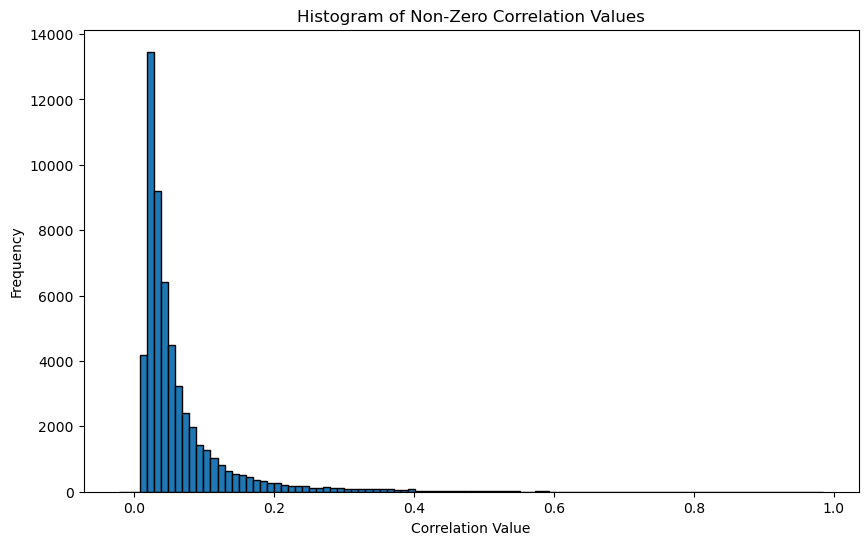

In [16]:
# Save with disease names
harmonized_open_targets.to_csv(harmonized_fname, index=False)
print(f"✓ Saved harmonized matrix to {harmonized_fname}")

# Save with ICD codes
harmonized_icd = harmonized_open_targets.copy()
# Map column names to ICD codes, handling the Dementia umbrella category
icd_dict_extended = {**icd_dict, 'Dementia': 'F00'}  # Dementia umbrella -> F00
harmonized_icd.columns = [icd_dict_extended.get(x, x) for x in harmonized_icd.columns]
harmonized_icd.to_csv(harmonized_fname.replace('.csv', '_icd.csv'), index=False)
print(f"✓ Saved ICD-coded matrix to {harmonized_fname.replace('.csv', '_icd.csv')}")

# Visualization of sparsity
all_values = harmonized_open_targets.values.flatten()
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]
zero_percentage = (zero_count / total_values) * 100

print(f"\nMatrix statistics:")
print(f"  Shape: {harmonized_open_targets.shape}")
print(f"  Total values: {total_values:,}")
print(f"  Zero values: {zero_count:,} ({zero_percentage:.2f}%)")
print(f"  Non-zero values: {len(non_zero_values):,} ({100-zero_percentage:.2f}%)")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(non_zero_values, bins=100, edgecolor='black')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Correlation Values')
plt.show()

## Step 7: Compare with Hospital Data and Generate Heatmaps

In [17]:
# Load diagnosis metadata
diag_df = pd.read_csv('data/Diagnosis_global_10years.csv')
diag_df = diag_df[diag_df['age_id'] < 9].iloc[:1080, :]
diag_df['ID'] = range(len(diag_df))
diag_df['English description'] = [
    icd10.find(x[0]).description if icd10.find(x[0]) else x[1] 
    for x in diag_df[['icd_code', 'descr']].values
]
diag_df['icd_global'] = diag_df['icd_global'].str.replace('__', '-')

print(f"Loaded hospital data: {len(diag_df)} diagnoses")
diag_df.head()

Loaded hospital data: 1080 diagnoses


,Unnamed: 0,diagnose_id,icd_code,descr,postion,age_id,age_range,icd_global,ID,English description
0,1,1,A00,Cholera,1,1,0-9,A00-0-9,0,Cholera
1,2,2,A01,Typhus abdominalis und Paratyphus,2,1,0-9,A01-0-9,1,Typhoid and paratyphoid fevers
2,3,3,A02,Sonstige Salmonelleninfektionen,3,1,0-9,A02-0-9,2,Other salmonella infections
3,4,4,A03,Shigellose [Bakterielle Ruhr],4,1,0-9,A03-0-9,3,Shigellosis
4,5,5,A04,Sonstige bakterielle Darminfektionen,5,1,0-9,A04-0-9,4,Other bacterial intestinal infections


In [18]:
# Load harmonized OpenTargets data with ICD codes
open_target_df = pd.read_csv(harmonized_fname.replace('.csv', '_icd.csv'))
open_target_df.index = open_target_df.columns

print(f"Loaded harmonized OpenTargets data: {open_target_df.shape}")
print(f"Sample:")
print(open_target_df.iloc[:5, :5])

Loaded harmonized OpenTargets data: (419, 419)
Sample:
     L83       L70       D59       D60       K35
L83  0.0  0.000000  0.000000  0.000000  0.000000
L70  0.0  0.000000  0.019601  0.053045  0.000000
D59  0.0  0.019601  0.000000  0.077958  0.016916
D60  0.0  0.053045  0.077958  0.000000  0.019806
K35  0.0  0.000000  0.016916  0.019806  0.000000


In [19]:
# PubMed search functions
Entrez.email = "x@y.com"

def search_pubmed_with_retry(disease1, disease2, max_results=20_000, retries=5, delay=0.5):
    """Search PubMed with exponential backoff retry."""
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    return 0

pubmed_cache = {}

def get_pubmed_count_cached(disease1, disease2):
    """Get PubMed count with caching."""
    key = (disease1.lower(), disease2.lower())
    if key not in pubmed_cache:
        pubmed_cache[key] = search_pubmed_with_retry(disease1, disease2)
    return pubmed_cache[key]

Found 10 hospital data files

  Collected 10 graphs

  Collected 10 graphs

Figure height: 20 inches (for 9 diseases)

Plotting F00 (Dementia)...
  Querying PubMed for 8 diseases...
    Progress: 0/8
  ✓ Heatmap created with 8 diseases (8 positive, 0 negative)

Plotting G30 (Alzheimer's disease)...
  Querying PubMed for 9 diseases...
    Progress: 0/9
  ✓ Heatmap created with 9 diseases (9 positive, 0 negative)

✓ Saved heatmap to dementia_heatmaps_50.pdf


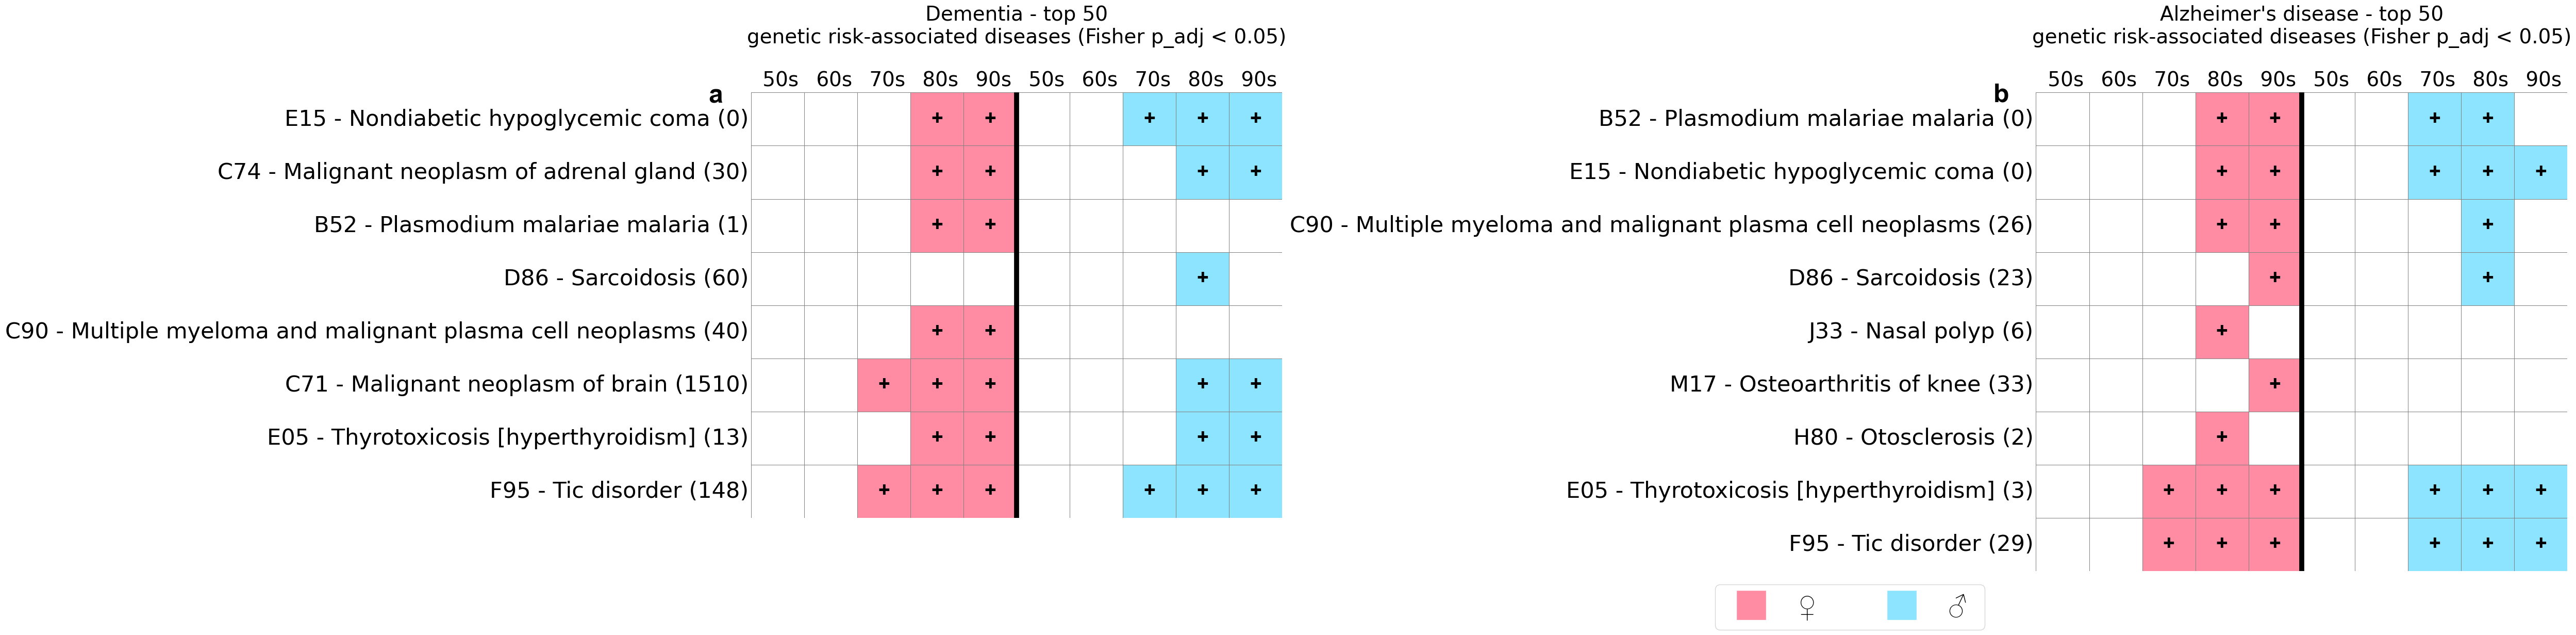

In [20]:
# Generate heatmaps comparing OpenTargets with hospital data

# Configuration
TOP_K = 50  # Top K genetic correlations to analyze (per direction: positive and negative)

# Sex-specific ICD codes that cannot appear in the opposite sex
MALE_ONLY_CODES = {
    'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49',
    'N50', 'N51', 'C61', 'C62', 'C63', 'D29', 'D40'
}
FEMALE_ONLY_CODES = {
    'N70', 'N71', 'N72', 'N73', 'N74', 'N75', 'N76', 'N77',
    'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89',
    'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'N96', 'N97', 'N98',
    'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58',
    'D25', 'D26', 'D27', 'D28', 'D39',
    'O00', 'O01', 'O02', 'O03', 'O04', 'O05', 'O06', 'O07', 'O08',
    'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16',
    'O20', 'O21', 'O22', 'O23', 'O24', 'O25', 'O26', 'O28', 'O29',
    'O30', 'O31', 'O32', 'O33', 'O34', 'O35', 'O36',
    'O40', 'O41', 'O42', 'O43', 'O44', 'O45', 'O46', 'O47', 'O48',
    'O60', 'O61', 'O62', 'O63', 'O64', 'O65', 'O66', 'O67', 'O68', 'O69',
    'O70', 'O71', 'O72', 'O73', 'O74', 'O75',
    'O80', 'O81', 'O82', 'O84', 'O85', 'O86', 'O87', 'O88', 'O89',
    'O90', 'O91', 'O92', 'O94', 'O95', 'O96', 'O97', 'O98', 'O99'
}

# Dementia codes
dementia_codes = {
    'F00': 'Dementia',
    'G30': "Alzheimer's disease"
}

# Load disease names from harmonized file
with open(harmonized_fname, 'r') as f:
    disease_names = f.readline().strip().split(',')

# Load hospital data files
rds_files = glob.glob("data/dementia_age_groups/*.rds")
print(f"Found {len(rds_files)} hospital data files")

# Map dementia codes to fisher_results keys
fisher_key_map = {
    'F00': 'Dementia',
    'G30': "Alzheimer's disease"
}

# Single pass: collect all data per dementia code
heatmap_data = {}  # code -> (df_out, disease_corr_sign)

for code in ['F00', 'G30']:
    print(f"\nCollecting data for {code} ({dementia_codes[code]})...")
    
    if code not in open_target_df.index:
        print(f"  Warning: Code {code} not found, skipping...")
        continue
    
    # Get Fisher-significant diseases for this code
    fisher_key = fisher_key_map[code]
    significant_diseases = None
    if fisher_key in fisher_results:
        significant_diseases = {d for d, v in fisher_results[fisher_key].items() if v[3]}
    
    df_out = pd.DataFrame(columns=['Graph', 'ICD10', 'Correlated disease', 'Num correlated diseases'])
    disease_corr_sign = {}
    ind = 0
    
    for f in rds_files:
        result = pyreadr.read_r(f)
        df = result[None]
        df.fillna(0, inplace=True)
        df.columns = diag_df['icd_code']
        df.index = diag_df['icd_code']
        df = df.loc[df.index.isin(open_target_df.index), df.columns.isin(open_target_df.columns)]
        
        # Merge dementia codes
        merge_codes = ['F00', 'F01', 'F02', 'F03']
        existing = [c for c in merge_codes if c in df.index and c in df.columns]
        if existing:
            merged_row = df.loc[existing].max(axis=0)
            merged_col = df[existing].max(axis=1)
            df.loc['F00'] = merged_row
            df['F00'] = merged_col
        
        if code not in df.index:
            continue
        
        row1 = open_target_df.loc[code]
        row2 = df.loc[code]
        
        # Select top K positive AND top K negative correlations
        row1_vals = row1.values
        top_k_pos = min(TOP_K, (row1_vals > 0).sum())
        top_k_neg = min(TOP_K, (row1_vals < 0).sum())
        
        pos_indices = np.argsort(-row1_vals)[:top_k_pos]
        neg_indices = np.argsort(row1_vals)[:top_k_neg]
        pos_indices = pos_indices[row1_vals[pos_indices] > 0]
        neg_indices = neg_indices[row1_vals[neg_indices] < 0]
        top_indices = np.unique(np.concatenate([pos_indices, neg_indices]))
        top_indices = top_indices[np.argsort(-np.abs(row1_vals[top_indices]))]
        
        top_disease_names_arr = np.array(disease_names)[top_indices]
        
        # Filter by Fisher significance
        if significant_diseases is not None:
            mask = np.array([d in significant_diseases for d in top_disease_names_arr])
            top_indices = top_indices[mask]
            top_disease_names_arr = top_disease_names_arr[mask]
        
        # Store correlation sign for each disease
        for idx, dname in zip(top_indices, top_disease_names_arr):
            disease_corr_sign[dname] = '+' if row1_vals[idx] > 0 else '-'
        
        row2_subset = row2.values[top_indices]
        
        try:
            correlated_diseases = top_disease_names_arr[np.nonzero(row2_subset)[0]]
        except TypeError:
            correlated_diseases = []
        
        df_out.loc[ind] = [
            f.split('/')[-1].split('.')[0].replace('All_OR_', ''),
            code,
            correlated_diseases,
            len(correlated_diseases)
        ]
        ind += 1
    
    heatmap_data[code] = (df_out, disease_corr_sign)
    print(f"  Collected {len(df_out)} graphs")

# Calculate dynamic figure height from collected data
disease_counts = {}
for code, (df_out, _) in heatmap_data.items():
    all_correlated = set()
    for _, row in df_out.iterrows():
        all_correlated.update(row['Correlated disease'])
    disease_counts[code] = len(all_correlated)

max_diseases = max(disease_counts.values()) if disease_counts else 30
fig_height = max(20, max_diseases * 0.5)
print(f"\nFigure height: {fig_height} inches (for {max_diseases} diseases)")

# Create figure with dynamic height
fig, axes = plt.subplots(1, 2, figsize=(50, fig_height))
fig.subplots_adjust(wspace=0.3)

# Generate heatmaps from collected data
for i, code in enumerate(['F00', 'G30']):
    if code not in heatmap_data:
        continue
    
    df_out, disease_corr_sign = heatmap_data[code]
    print(f"\nPlotting {code} ({dementia_codes[code]})...")
    
    if len(df_out) == 0:
        print(f"  Warning: No data, skipping...")
        continue
    
    # Create disease-graph mapping
    gr_dis_dict = dict(zip(df_out['Graph'], df_out['Correlated disease']))
    dis_gr_dict = {}
    
    for graph, dis in gr_dis_dict.items():
        for d in dis:
            if d in dis_gr_dict:
                dis_gr_dict[d].append(graph)
            else:
                dis_gr_dict[d] = [graph]
    
    if len(dis_gr_dict) == 0:
        continue
    
    # Create heatmap data
    dis_gr_df = pd.DataFrame(
        {(k, ','.join(v)) for k, v in dis_gr_dict.items()},
        columns=['Disease', 'Detected in']
    )
    
    graph_cols_ordered = sorted(gr_dis_dict.keys())
    for gr in graph_cols_ordered:
        dis_gr_df[gr.replace('_Age_', ' ') + '0'] = dis_gr_df['Detected in'].apply(
            lambda x: 1 if gr in x else 0
        )
    
    dis_gr_df.rename(columns={'Disease': dementia_codes[code]}, inplace=True)
    dis_gr_df = dis_gr_df.drop(columns=['Detected in'])
    dis_gr_df.set_index(dementia_codes[code], inplace=True)
    
    # Sex-specific filtering: zero out impossible sex-disease combinations
    female_cols = [col for col in dis_gr_df.columns if 'Female' in col]
    male_cols = [col for col in dis_gr_df.columns if 'Male' in col]
    
    for disease in dis_gr_df.index:
        cleaned = disease.replace('"', '')
        if cleaned in icd_dict:
            disease_icd = icd_dict[cleaned]
            if disease_icd in MALE_ONLY_CODES:
                dis_gr_df.loc[disease, female_cols] = 0
            elif disease_icd in FEMALE_ONLY_CODES:
                dis_gr_df.loc[disease, male_cols] = 0
    
    # Remove diseases that became all zeros after sex filtering
    dis_gr_df = dis_gr_df.loc[~(dis_gr_df == 0).all(axis=1)]
    
    # Build correlation sign list aligned with rows
    row_signs = [disease_corr_sign.get(disease, '+') for disease in dis_gr_df.index]
    
    # Sort rows: positive correlations first, then negative
    sort_order = sorted(range(len(row_signs)), key=lambda k: (0 if row_signs[k] == '+' else 1, k))
    dis_gr_df = dis_gr_df.iloc[sort_order]
    row_signs = [row_signs[k] for k in sort_order]
    
    # Color males differently (value 2 for male detected, 1 for female detected, 0 for not)
    for col in dis_gr_df.columns:
        if 'Male' in col:
            dis_gr_df[col] = dis_gr_df[col].apply(lambda x: (x + 1) if x else x)
    
    dis_gr_df.columns = [la.replace("Female", "").replace("Male", "") for la in dis_gr_df.columns]
    
    # Add PubMed counts to labels
    print(f"  Querying PubMed for {len(dis_gr_df)} diseases...")
    new_index = []
    diseases_to_remove = []
    signs_to_remove = []
    
    for j, disease in enumerate(dis_gr_df.index):
        if j % 10 == 0:
            print(f"    Progress: {j}/{len(dis_gr_df)}")
        
        cleaned_disease = disease.replace('"', '')
        
        if cleaned_disease in icd_dict:
            icd_code = icd_dict[cleaned_disease]
        else:
            print(f"    ⚠️  No ICD code for '{cleaned_disease}', skipping...")
            diseases_to_remove.append(disease)
            signs_to_remove.append(j)
            continue
        
        # Shorten long disease descriptions
        if icd_code == 'I22' or (icd_code == 'K56'):
            words = cleaned_disease.split()
            cleaned_disease = ' '.join(words[:-2])
        
        pubmed_count = get_pubmed_count_cached(dementia_codes[code], cleaned_disease)
        
        new_lab = f"{icd_code} - {cleaned_disease} ({pubmed_count})".replace('"', '')
        new_index.append(new_lab)
    
    # Remove diseases without valid ICD codes
    if diseases_to_remove:
        print(f"  Removing {len(diseases_to_remove)} diseases without ICD codes")
        dis_gr_df = dis_gr_df.drop(diseases_to_remove)
        row_signs = [s for j, s in enumerate(row_signs) if j not in signs_to_remove]
    
    dis_gr_df.index = new_index
    
    # Plot heatmap
    plt.rcParams["font.family"] = "Arial"
    male_female_color = ["#ff8ca3", "#8ce4ff"]
    cmap = sns.color_palette(["white"] + male_female_color)
    
    ax = sns.heatmap(
        dis_gr_df,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True,
        ax=axes[i]
    )
    
    # Add +/- annotations on colored cells
    for row_idx in range(len(dis_gr_df)):
        sign = row_signs[row_idx]
        for col_idx in range(len(dis_gr_df.columns)):
            cell_val = dis_gr_df.iloc[row_idx, col_idx]
            if cell_val > 0:  # colored cell (female=1, male=2)
                ax.text(col_idx + 0.5, row_idx + 0.5, sign,
                        ha='center', va='center',
                        fontsize=28, fontweight='bold', color='black')
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', labelrotation=0, labelsize=28)
    ax.tick_params(axis='y', labelsize=31)
    ax.tick_params(axis='both', which='both', length=0)
    # Add "s" to every column label
    ax.set_xticklabels([f"{label.get_text()}s" for label in ax.get_xticklabels()])

    title_line1 = f'{dementia_codes[code]} - top {TOP_K}'
    title_line2 = 'genetic risk-associated diseases (Fisher p_adj < 0.05)'
    ax.set_title(title_line1 + '\n' + title_line2 + '\n', size=28)
    
    mid = len(dis_gr_df.columns) // 2
    ax.axvline(x=mid, color='black', linewidth=7)
    
    # Draw horizontal separator between positive and negative correlations
    n_positive = sum(1 for s in row_signs if s == '+')
    if 0 < n_positive < len(row_signs):
        ax.axhline(y=n_positive, color='black', linewidth=3, linestyle='--')
    
    # Position label
    label = chr(97 + i)
    ax.text(-0.08, 1.02, f'{label}', transform=ax.transAxes,
            fontsize=36, fontweight='bold', va='top', ha='left')
    
    print(f"  ✓ Heatmap created with {len(dis_gr_df)} diseases ({n_positive} positive, {len(row_signs) - n_positive} negative)")

# Add legend
labels = ['♀ ', '♂ ']
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=labels[i],
           markerfacecolor=male_female_color[i], markersize=42)
    for i in range(2)
]

plt.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(-0.35, -0.15),
    ncol=2,
    frameon=True,
    fontsize=36
)

# Adjust layout
plt.tight_layout()
pos1 = axes[0].get_position()
pos2 = axes[1].get_position()
new_y0 = pos1.y0 + pos1.height - pos2.height
axes[1].set_position([pos2.x0, new_y0, pos2.width, pos2.height])

# Save
output_file = f"dementia_heatmaps_{TOP_K}.pdf"
plt.savefig(output_file, dpi=300, format='pdf', bbox_inches='tight')
print(f"\n✓ Saved heatmap to {output_file}")
plt.show()

## Summary

This notebook successfully:
1. Loaded OpenTargets disease-gene associations
2. Mapped diseases to ICD10 codes using semantic embeddings (similarity threshold = 0.8)
3. **Merged gene association vectors** for diseases with the same ICD code (before correlation)
4. **Created Dementia umbrella** at the gene-vector level (max across subtypes), ensuring a coherent gene profile
5. Computed Pearson correlations between harmonized diseases (keeping both positive and negative)
6. **Applied p-value filtering** (BH FDR < 0.05) to zero out non-significant correlations
7. Performed Fisher's exact test for gene overlap significance (FDR < 0.05)
8. Generated comparison heatmaps with hospital data, with:
   - Sex-specific disease filtering (male-only diseases removed from female columns and vice versa)
   - +/- annotations indicating positive or negative genetic correlation
   - Only Fisher-significant diseases included